In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter(X, y, random_state=0):

    from sklearn.manifold import TSNE
    X_ = TSNE(n_components=3,random_state=random_state,perplexity=5).fit_transform(X)
    print(X_[0])
    labels = set(y)   
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for label in labels:
#         indexes = np.where(y==label)[0]
        indexes = []
        for inx in range(X.shape[0]):
            if label==all_ids[inx]:
                indexes.append(inx)
        scatter = X_[indexes,:]  
        ax.scatter(scatter[:,0], scatter[:,1])
    plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("************ NOTE: The torch device is:", device)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,3,2,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Conv2d(16,32,3,2,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Conv2d(32,64,3,2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Conv2d(64,128,3,2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Conv2d(128,256,3,2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Flatten(),
            nn.Linear(12* 21* 256,100),
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            #nn.Dropout(0.2)
        )
        
        self.fc = nn.Sequential( 
            nn.Linear(100,12* 21* 256),
            #nn.BatchNorm2d(6*10*128),
            nn.ReLU(),
            #nn.Dropout(0.2)
        )
        
        self.decoder = nn.Sequential( 
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), 
            nn.Sigmoid()
        )


    def forward(self, anchor, positive, negative):
        embedded_anchor   = self.encoder(anchor)
        embedded_positive = self.encoder(positive)
        embedded_negative = self.encoder(negative)
        
        input_to_decoder_anchor   = self.fc(embedded_anchor).view(-1,256,12,21)
        input_to_decoder_positive = self.fc(embedded_anchor).view(-1,256,12,21)
        input_to_decoder_negative = self.fc(embedded_anchor).view(-1,256,12,21)
        
        decoded_anchor   = self.decoder(input_to_decoder_anchor)
        decoded_positive = self.decoder(input_to_decoder_positive)
        decoded_negative = self.decoder(input_to_decoder_negative)
        
        return decoded_anchor, decoded_positive, decoded_negative, embedded_anchor, embedded_positive, embedded_negative
        
    def get_embeding(self,x):
        return self.encoder(x)

model = Net()        
model=model.to(device)
epoch=93
model.load_state_dict(torch.load( '/../../../models/img/AE/alpha_1/emb_100/model/{}.pth'.format(epoch),
                      map_location=device))
model.eval()


************ NOTE: The torch device is: cpu


Net(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Flatten()
    (16): Linear(in_features=64512, out_f

In [2]:
from tqdm import tqdm 
import numpy as np
from bob.bio.vein.configurations.utfvp import database
import bob.io.base

from bob.bio.vein.preprocessor import NoCrop, TomesLeeMask, HuangNormalization, \
    NoFilter, Preprocessor

preprocessor = Preprocessor(
    crop=NoCrop(),
    mask=TomesLeeMask(),
    normalize=HuangNormalization(),
    filter=NoFilter(),
    )


from bob.bio.vein.extractor import WideLineDetector
WLD_extractor = WideLineDetector()


all_Files = database.objects(protocol='nom', groups='eval')


all_ids = []
for i,obj in tqdm(enumerate(all_Files)):
    all_ids.append(obj.client_id)
selected_ids = list(set(all_ids))[:5]
######################################################################    
import time 
from tqdm import tqdm
all_features = []
all_features_AE = []
all_ids = []
for i,obj in enumerate(all_Files):
    
    if obj.client_id in selected_ids:
        path=obj.make_path('path_to_utfvp_database','.png')
        image = bob.io.base.load(path)
        #################################
        from tensorflow.keras.preprocessing.image import ImageDataGenerator
        datagen = ImageDataGenerator(rotation_range=7,
                                     width_shift_range=0.025,
                                     height_shift_range=0.025,
                                     channel_shift_range=0.075,
                                     zoom_range=(0.95,1.05)
                                     )
        image_reshape = np.reshape(image, [1, 380, 672, 1])
        itr=0
        for image in datagen.flow(image_reshape, seed=itr):
            itr +=1
            if itr>20:
                break
            image_and_mask = preprocessor(image[0,:,:,0])
            #WLD_feature = image_and_mask[0]
            WLD_feature = image[0,:,:,0]
            print(i,itr)
            
            WLD_feature_AE=np.zeros([1,1,WLD_feature.shape[0]+4,WLD_feature.shape[1]])
            WLD_feature_AE[0,0,2:-2,:]=WLD_feature[:,:]/255.
            WLD_feature_AE_ = torch.tensor(WLD_feature_AE, requires_grad=False).float().to(device)
            WLD_feature_AE = model.get_embeding(WLD_feature_AE_).cpu().detach().numpy()

            all_features_AE.append(WLD_feature_AE)

            all_ids.append(obj.client_id)

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "
768it [00:00, 540383.40it/s]
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters


28 1
28 2
28 3
28 4
28 5
28 6
28 7
28 8
28 9
28 10
28 11
28 12
28 13
28 14
28 15
28 16
28 17
28 18
28 19
28 20
29 1
29 2
29 3
29 4
29 5
29 6
29 7
29 8
29 9
29 10
29 11
29 12
29 13
29 14
29 15
29 16
29 17
29 18
29 19
29 20
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
30 11
30 12
30 13
30 14
30 15
30 16
30 17
30 18
30 19
30 20
31 1
31 2
31 3
31 4
31 5
31 6
31 7
31 8
31 9
31 10
31 11
31 12
31 13
31 14
31 15
31 16
31 17
31 18
31 19
31 20
128 1
128 2
128 3
128 4
128 5
128 6
128 7
128 8
128 9
128 10
128 11
128 12
128 13
128 14
128 15
128 16
128 17
128 18
128 19
128 20
129 1
129 2
129 3
129 4
129 5
129 6
129 7
129 8
129 9
129 10
129 11
129 12
129 13
129 14
129 15
129 16
129 17
129 18
129 19
129 20
130 1
130 2
130 3
130 4
130 5
130 6
130 7
130 8
130 9
130 10
130 11
130 12
130 13
130 14
130 15
130 16
130 17
130 18
130 19
130 20
131 1
131 2
131 3
131 4
131 5
131 6
131 7
131 8
131 9
131 10
131 11
131 12
131 13
131 14
131 15
131 16
131 17
131 18
131 19
131 20
596 1
596 2
596 3
596 4
596 5
59

### AE

[104.68637 283.29895 126.54368]


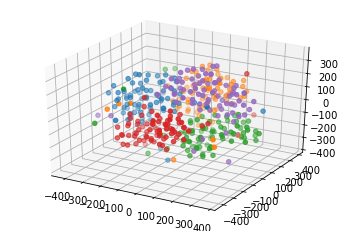

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter(X, y, random_state=0):

    from sklearn.manifold import TSNE
    X_ = TSNE(n_components=3,random_state=random_state,perplexity=30,early_exaggeration=30,n_iter=5000).fit_transform(X)
    print(X_[0])
    labels = set(y)   
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for label in labels:
#         indexes = np.where(y==label)[0]
        indexes = []
        for inx in range(X.shape[0]):
            if label==all_ids[inx]:
                indexes.append(inx)
        scatter = X_[indexes,:]  
        ax.scatter(scatter[:,0], scatter[:,1], scatter[:,2])
    plt.show()
    
plot_scatter(np.reshape(np.array(all_features_AE),(-1,100)), all_ids, random_state=2)

[104.68637 283.29895 126.54368]


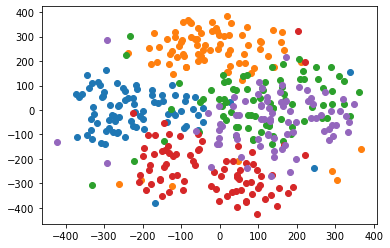

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter(X, y, random_state=0,save_fig=None):

    from sklearn.manifold import TSNE
    X_ = TSNE(n_components=3,random_state=random_state,perplexity=30,early_exaggeration=30,n_iter=5000).fit_transform(X)
    print(X_[0])
    labels = set(y)   
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for label in labels:
#         indexes = np.where(y==label)[0]
        indexes = []
        for inx in range(X.shape[0]):
            if label==all_ids[inx]:
                indexes.append(inx)
        scatter = X_[indexes,:]  
        ax.scatter(scatter[:,0], scatter[:,1])
    if save_fig!=None:
        plt.savefig(save_fig,dpi=120)
    plt.show()
        
    
plot_scatter(np.reshape(np.array(all_features_AE),(-1,100)), all_ids, random_state=2, save_fig='AE.pdf')